In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.Neural_Network_v2 import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv("Datasets/transformed_train_df.csv")
print("Original dataset size: ",dataset.shape)

dataset['Label'], uniques = pd.factorize(dataset['Label'])
# print(dataset.head())
sampled_df = dataset.groupby('Label').apply(lambda x: x.sample(frac=0.05, random_state=42)).reset_index(drop=True)
print("Sampled dataset size: ",sampled_df.shape)

print(f"Number of unique values in the 'Label' column: {dataset['Label'].nunique()}")

Original dataset size:  (313627, 21)
Sampled dataset size:  (15680, 21)
Number of unique values in the 'Label' column: 11


In [4]:
# split the dataset
X_train = sampled_df.iloc[:,:20]
Y_train = sampled_df["Label"]
print("Sampled X size: ",X_train.shape)
print("Sampled Y size: ",Y_train.shape)

print("Sampled X head: ",X_train.head())
print("Sampled Y head: ",Y_train.head())

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

Sampled X size:  (15680, 20)
Sampled Y size:  (15680,)
Sampled X head:     FAMD_Component_1  FAMD_Component_2  FAMD_Component_3  FAMD_Component_4  \
0          1.106166         -1.091306          7.027377          4.311347   
1          0.954526         -1.033375         -0.491732         -1.109583   
2          0.643954         -1.227613         -5.401073         -3.618718   
3          1.094598         -1.110412         -1.769525         -2.175249   
4          1.108363         -1.127580         -1.382770         -1.992035   

   FAMD_Component_5  FAMD_Component_6  FAMD_Component_7  FAMD_Component_8  \
0         -1.536011          5.063335          1.261412         -6.509035   
1         -0.145088         -2.437912         -1.213178         -0.716131   
2         -5.784012          4.060536          1.793040          0.950605   
3         -2.229234         -2.066392         -1.881398         -1.683342   
4         -2.401953         -1.963375         -2.065242         -1.428270   

  

In [13]:
# lets make our NN model layers
noIterations=15680
noOfEpochs=10
learningRate = 0.001

layer1_noNeurons = 1024
layer2_noNeurons = 512
layer3_noNeurons = 128

layer1 = Layer(20,layer1_noNeurons,activation='relu', learning_rate=learningRate)
layer2 = Layer(layer1_noNeurons,layer2_noNeurons,activation='relu', learning_rate=learningRate)
layer3 = Layer(layer2_noNeurons,layer3_noNeurons,activation='relu', learning_rate=learningRate)
layer4 = Layer(layer3_noNeurons,11,activation='softmax', learning_rate=learningRate)


errors = np.empty(noIterations)
final_errors = np.empty(noOfEpochs)


In [14]:
# Main training loop
for j in range(noOfEpochs):
    errors = np.empty(noIterations)
    indices = np.arange(noIterations)
    np.random.shuffle(indices)
    for index in indices:
        # Randomly select a training sample
        # index = np.random.choice(X_train.shape[0], 1)
        input_sample = np.squeeze(X_train[index])
        # input_sample = X_train[index]
        target_sample = Y_train[index]
        one_hot = np.zeros(11)
        one_hot[target_sample] = 1
    
        # Forward propagation
        layer1.train(input_sample)
        layer2.train(layer1.out)
        layer3.train(layer2.out)
        layer4.train(layer3.out)
    
        # Backpropagation
        layer4.backprop(cross_entropy_error(layer4.out, one_hot, derivative=True))
        layer3.backprop(layer4.delip)
        layer2.backprop(layer3.delip)
        layer1.backprop(layer2.delip)
    
        # Record error
        errors[index] = cross_entropy_error(layer4.out, one_hot)
    
    final_errors[j]=np.mean(errors)
    print(f"Completed {j} epochs, average error: {final_errors[j]}")
            # print(f"Completed {i} steps, Current Error: {np.mean(errors[i])}")

Completed 0 epochs, average error: 14.269642073961426
Completed 1 epochs, average error: 15.69056731084261


KeyboardInterrupt: 

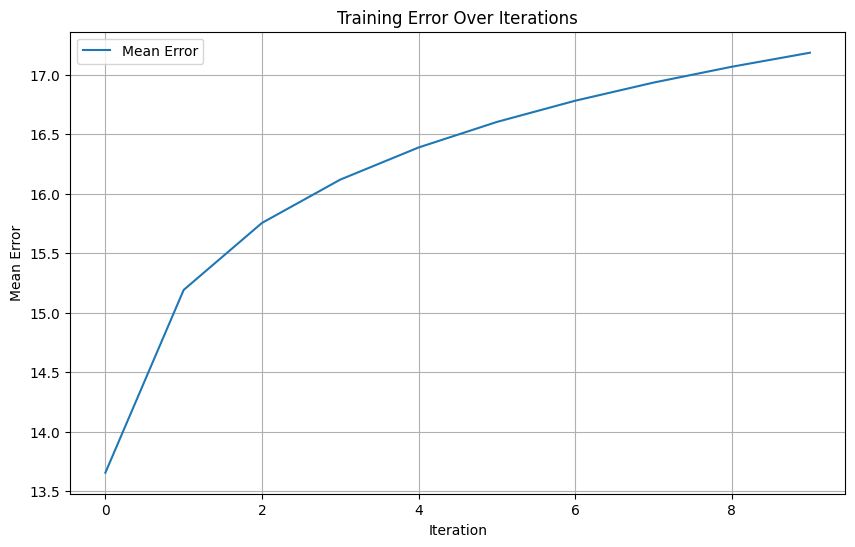

In [12]:
# Calculate mean error for each iteration
# mean_errors = final_errors.mean(axis=0)  # Averaging over all output neurons

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(final_errors, label="Mean Error")
plt.title("Training Error Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean Error")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Testing function that takes network input and predicts output
def forward(input_data):
    layer1.train(input_data)
    layer2.train(layer1.out)
    layer3.train(layer2.out)
    layer4.train(layer3.out)
    return layer4.out

In [ ]:
# Testing loop
print("\nTesting Predictions:")
for _ in range(20):
    index = np.random.choice(X_train.shape[0], 1)
    test_sample = np.squeeze(X_train[index])
    prediction = forward(test_sample)
    print("Input:", test_sample)
    print("Predicted Output:", prediction)
    print("Predicted Class:", np.argmax(prediction), "\n")


In [ ]:
# Save the parameters of the network and its training error
layer1.save('layer1')
layer2.save('layer2')
layer3.save('layer3')
layer4.save('layer4')
np.save('error.npy', errors)